In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar5=pd.read_csv('Solar 5.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar5['datetime']=pd.to_datetime(solar5['datetime'], format='%Y-%m-%d %H:%M:%S')
solar5= solar5.set_index('datetime')
solar5= solar5.asfreq('H')

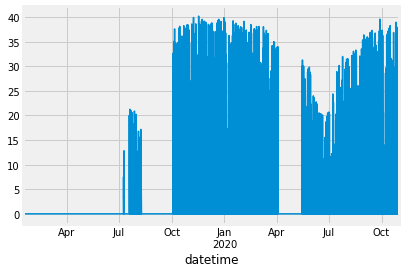

In [4]:
solar5['series_value'].plot()

In [5]:
#Split Train-Val for Solar5
# ==============================================================================
start_train='2019-10-01 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar5train=solar5.loc[start_train:end_train, :]
solar5val=solar5.loc[start_val:end_val, :]
solar5test=solar5.loc[start_test:, :]

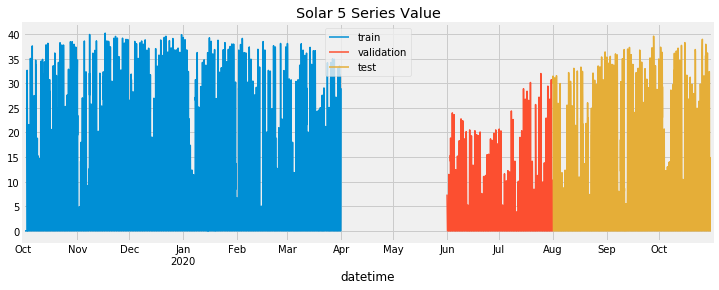

In [6]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar5train['series_value'].plot(ax=ax, label='train')
solar5val['series_value'].plot(ax=ax, label='validation')
solar5test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 5 Series Value')
ax.legend();

In [7]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:18:46 
Last fit date: None 
Skforecast version: 0.4.3 

In [8]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar5train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:11,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:09,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:08,  1.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:13<00:02,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:11,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:13,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:04,  1.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:11,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:07,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.31s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:02<00:00, 15.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 125.08479730398156



In [9]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
47  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
36  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
37  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
38  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
39  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
40  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
46  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
42  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
43  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
44  [1, 2, 3, 23, 24, 25, 71, 72, 73]   

                                               params      metric  \
47  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  125.084797   
36  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  125.084797   
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  125.084797   
38  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  125.084797   
39  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  125.084797   
40  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  125.084797   
46  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  125.084797   
42  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  125.084797   
43  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  125.084797   
44  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  125.084797   

    learning_rate  max_depth  n_estimators  
47           0.10       10.0         500.0  
36           0.01        3.0         100.0  
37           0.01        3.0         500.0  
38           0.01        5.0         100.0  
39           0.01        5.0         500.0  
40           0.01       10.0         100.0  
46           0.10       10.0         100.0  
42           0.10        3.0         100.0  
43           0.10        3.0         500.0  
44           0.10        5.0         100.0

In [10]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar5['series_value'],
    initial_train_size = len(solar5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 41.40569469547968


In [11]:
# Predictions
# ==============================================================================
predictions

pred
2020-08-01 01:00:00  19.656707
2020-08-01 02:00:00  21.137383
2020-08-01 03:00:00  22.506348
2020-08-01 04:00:00  26.983364
2020-08-01 05:00:00  14.241476
...                        ...
2020-10-31 19:00:00   0.607610
2020-10-31 20:00:00   3.474722
2020-10-31 21:00:00  10.070834
2020-10-31 22:00:00  16.523498
2020-10-31 23:00:00  24.294890

[2207 rows x 1 columns]

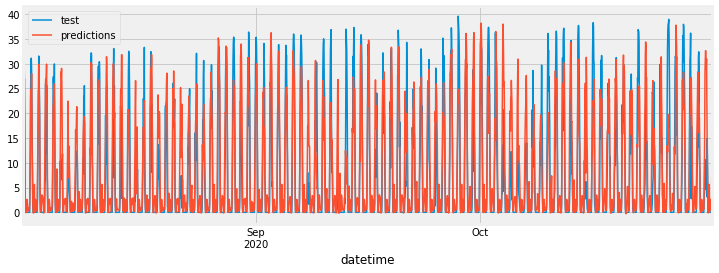

In [12]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar5test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [13]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [14]:
solar5test=solar5test.dropna()
solar5train=solar5train.dropna()

In [16]:
LGBM_Mase=mean_absolute_scaled_error(solar5test.reset_index()['series_value'],predictions.reset_index()['pred'],solar5train.reset_index()['series_value'])

In [17]:
# CatBoost Forecasting
# ==============================================================================

In [18]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x0000017BAAC53E48> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-25 01:36:04 
Last fit date: None 
Skforecast version: 0.4.3 

In [21]:
    # Grid search of hyperparameters and lags
    # ==============================================================================
    # Regressor hyperparameters

    param_grid = {
        'n_estimators': [100, 500],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1]
        }
    lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

    results_grid = grid_search_forecaster(
                            forecaster         = cat_forecaster,
                            y                  = solar5.loc[:end_val, 'series_value'],
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(solar5train)),
                            lags_grid          = lags_grid,
                            param_grid         = param_grid,
                            steps              = 36,
                            )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:20<03:42, 20.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:56<04:57, 29.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [01:46<05:52, 39.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [02:56<06:50, 51.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [04:12<06:59, 59.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [05:47<07:11, 71.88s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [07:25<06:42, 80.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [09:17<06:02, 90.57s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [11:26<05:08, 102.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [14:04<03:59, 119.66s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|████████████████████████████████   | 11/12 [16:31<02:07, 127.98s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                 | 1/12 [02:50<31:10, 170.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████                              | 2/12 [05:54<29:44, 178.41s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████                           | 3/12 [09:31<29:23, 195.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [13:59<29:55, 224.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [18:29<28:07, 241.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [22:54<24:54, 249.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [27:49<22:01, 264.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [33:01<18:37, 279.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [38:08<14:23, 287.82s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [43:24<09:53, 296.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|████████████████████████████████   | 11/12 [48:43<05:03, 303.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|██▊                               | 1/12 [16:33<3:02:10, 993.66s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|█████▌                           | 2/12 [33:33<2:48:07, 1008.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|████████▌                         | 3/12 [40:00<1:48:45, 725.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|██████████▋                     | 4/12 [1:00:57<2:04:42, 935.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|████████████▉                  | 5/12 [1:21:01<2:00:24, 1032.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|███████████████▌               | 6/12 [1:39:41<1:46:11, 1061.86s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|██████████████████             | 7/12 [1:59:11<1:31:26, 1097.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████▋          | 8/12 [2:18:21<1:14:16, 1114.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|████████████████████████▊        | 9/12 [2:35:32<54:24, 1088.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████▋     | 10/12 [2:48:55<33:20, 1000.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|██████████████████████████████▎  | 11/12 [3:00:55<15:14, 914.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|██▊                               | 1/12 [08:54<1:38:01, 534.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|█████▋                            | 2/12 [16:16<1:20:00, 480.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|████████▌                         | 3/12 [22:08<1:03:12, 421.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [26:21<47:20, 355.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [28:51<32:48, 281.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [29:35<20:03, 200.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [29:43<11:26, 137.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [29:50<06:23, 95.98s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [29:57<03:24, 68.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [30:04<01:38, 49.43s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [30:12<00:36, 36.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████| 4/4 [4:57:04<00:00, 4456.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 78.3698767142941



In [22]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = solar5['series_value'],
    initial_train_size = len(solar5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 35.42692077380203


In [23]:
CatBoost_MASE=mean_absolute_scaled_error(solar5test.reset_index()['series_value'],cat_predictions.reset_index()['pred'],solar5train.reset_index()['series_value'])

In [24]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [25]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = solar5.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar5train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:09<01:39,  9.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:18<01:31,  9.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:27<01:21,  9.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:36<01:12,  9.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:44<01:02,  8.89s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:54<00:53,  9.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:02<00:44,  8.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:11<00:35,  8.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:20<00:26,  8.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:29<00:17,  8.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:37<00:08,  8.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:08<01:36,  8.79s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:18<01:31,  9.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:26<01:20,  8.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:36<01:14,  9.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:45<01:03,  9.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:54<00:55,  9.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:03<00:45,  9.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:13<00:36,  9.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:21<00:27,  9.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:30<00:18,  9.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:39<00:08,  8.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:09<01:40,  9.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:18<01:34,  9.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:27<01:21,  9.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:37<01:14,  9.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:46<01:04,  9.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:56<00:56,  9.48s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:05<00:46,  9.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:14<00:37,  9.31s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:23<00:27,  9.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:32<00:18,  9.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:41<00:09,  9.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:08<01:34,  8.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:17<01:27,  8.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:26<01:18,  8.73s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:34<01:10,  8.75s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:43<01:01,  8.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:52<00:52,  8.82s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:01<00:43,  8.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:10<00:35,  8.79s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:18<00:26,  8.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:27<00:17,  8.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:36<00:08,  8.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 9131
    Number of folds: 254
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-17 14:00:00 -- 2019-07-19 01:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-19 02:00:00 -- 2019-07-20 13:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-20 14:00:00 -- 2019-07-22 01:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-22 02:00:00 -- 2019-07-23 13:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2019-07-17 13:00:00
    Validation: 2019-07-23 14:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [07:11<00:00, 107.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 84.28431471905668



In [26]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = solar5['series_value'],
    initial_train_size = len(solar5.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 33.665324270461575


In [27]:
XGB_MASE=mean_absolute_scaled_error(solar5test.reset_index()['series_value'],XGB_predictions.reset_index()['pred'],solar5train.reset_index()['series_value'])

In [28]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('s5_actual_additive.csv')

In [29]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [30]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [31]:
prophet=prophet.dropna()

In [32]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:07,  1.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:06,  1.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:06,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:03<00:05,  1.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:05,  1.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:03,  1.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:07<00:02,  1.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:07<00:01,  1.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:08<00:00,  1.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:07,  1.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:06,  1.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:07,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:06,  1.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:06,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:06<00:04,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:07<00:03,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:08<00:02,  1.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:09<00:01,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:09<00:00,  1.12it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:08,  1.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:07,  1.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:09,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:07,  1.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:08,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:02,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:00,  1.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:05,  1.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:06,  1.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:05,  1.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:02<00:06,  1.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:03<00:05,  1.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:04<00:05,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:03,  1.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:05<00:02,  1.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:06<00:02,  1.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:07<00:01,  1.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:07<00:00,  1.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 10596
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-01-15 13:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:43<00:00, 10.76s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 10.636600726442117



In [33]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
44                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   

                                               params     metric  \
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  10.636601   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  10.977173   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  11.321845   
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  11.855952   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  12.079342   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  12.138297   
17  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  12.195201   
5   {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  13.064094   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  13.546194   
44  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  13.734664   

    learning_rate  max_depth  n_estimators  
27           0.01        5.0         500.0  
29           0.01       10.0         500.0  
32           0.10        5.0         100.0  
15           0.01        5.0         500.0  
34           0.10       10.0         100.0  
20           0.10        5.0         100.0  
17           0.01       10.0         500.0  
5            0.01       10.0         500.0  
22           0.10       10.0         100.0  
44           0.10        5.0         100.0

In [34]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 31.113158921245024


In [35]:
# Predictions
# ==============================================================================
prophet_predictions

pred
2020-08-01 01:00:00  10.079299
2020-08-01 02:00:00  13.924062
2020-08-01 03:00:00  14.366694
2020-08-01 04:00:00  10.912968
2020-08-01 05:00:00   7.742952
...                        ...
2020-10-31 19:00:00   3.723242
2020-10-31 20:00:00   4.047651
2020-10-31 21:00:00   5.999580
2020-10-31 22:00:00   8.522923
2020-10-31 23:00:00  10.422640

[2207 rows x 1 columns]

In [36]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [37]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [38]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [39]:
LightGBM_Prophet_MASE

3.0137874133092253

In [40]:
LGBM_Mase

1.3012079782044488

In [41]:
CatBoost_MASE

1.1024759474266235

In [42]:
XGB_MASE

1.0102137198812242